# PROJECT 12 [한-영 번역기 만들기]

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.6.0


# 데이터 정제

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng) # kor eng 쌍

    cleaned_corpus = []
    for sen_pair in zip(kor, eng):
        cleaned_corpus.append(sen_pair)
    cleaned_corpus = list(set(cleaned_corpus))
    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [4]:
cleaned_corpus[:3]

[("이라크전 준비에 있어 럼스펠드는 이라크전에 반대했던 프랑스, 독일등을 '구 유럽'이라며 날카롭게 비판했다.",
  'In the run-up to the Iraq war, Rumsfeld sharply criticized nations opposed to the conflict specifically France and Germany referring to them as "Old Europe.'),
 ('그러나 15일 차베스 대통령은 쿠바를 방문해 피델 카스트로와 회담을 갖은 자리에서 베네수엘라 인구의 38%를 차지하고 있는 빈민층 2700만명을 위한 물질적 구제 정책은 염두하고 있지 않다고 밝혔다.',
  "But Chavez, who was in Cuba Monday visiting communist leader Fidel Castro, said he wants to focus less on material goals for Venezuela's 27 million people, 38 percent of whom live in poverty."),
 ('지난 달 고용주들이 159,000개의 일자리를 없앴다는 노동부의 발표 후 실업률은 6.1%를 기록하고 있습니다.',
  "As for unemployment, it's at 6.1% after the Labor Department reported employers cut 159,000 jobs last month;")]

In [5]:
def preprocess_sentence(sentence):
    
    sentence = sentence.lower()
    sentence = re.sub(r"[^0-9가-힣a-zA-Z?.!,]+", " ", sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    return sentence

# Sentencepiece로 토크나이징

In [6]:
import sentencepiece as spm

def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    
    temp_file = os.getenv('HOME') + f'/aiffel/transformer/corpus_{lang}.txt'
    
    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')
    
    spm.SentencePieceTrainer.Train(
        f'--input={temp_file} --pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} \
        --unk_id={unk_id} --model_prefix=spm_{lang} --vocab_size={vocab_size}'
    )
    
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'spm_{lang}.model')

    return tokenizer

In [61]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k = pair[0]
    e = pair[1]

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/transformer/corpus_ko.txt --pad_id=0 --bos_id=1 --eos_id=2         --unk_id=3 --model_prefix=spm_ko --vocab_size=20000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/transformer/corpus_ko.txt
  input_format: 
  model_prefix: spm_ko
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  

True

: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  escape_whitespaces: 1
  normalization_rule_tsv: 
}
denormalizer_spec {}
trainer_interface.cc(329) LOG(INFO) SentenceIterator is not specified. Using MultiFileSentenceIterator.
trainer_interface.cc(178) LOG(INFO) Loading corpus: /aiffel/aiffel/transformer/corpus_en.txt
trainer_interface.cc(385) LOG(INFO) Loaded all 78957 sentences
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <pad>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <s>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: </s>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <unk>
trainer_interface.cc(405) LOG(INFO) Normalizing sentences...
trainer_interface.cc(466) LOG(INFO) all chars count=10789012
trainer_interface.cc(477) LOG(INFO) Done: 99.9506% characters are covered.
trainer_interface.cc(487) LOG(INFO) Alphabe

In [62]:
tokensIDs = ko_tokenizer.EncodeAsIds(cleaned_corpus[0][0])
print(tokensIDs)

[2041, 560, 13, 567, 6632, 6, 8841, 597, 192, 221, 19994, 455, 1649, 5, 8, 3, 497, 442, 3, 2620, 55, 672, 579, 9823, 4111, 19998]


In [63]:
tokensIDs = ko_tokenizer.encode_as_pieces(cleaned_corpus[0][0])
print(tokensIDs)

['▁이라크전', '▁준비', '에', '▁있어', '▁럼스펠드', '는', '▁이라크전에', '▁반대', '했던', '▁프랑스', ',', '▁독일', '등', '을', '▁', "'", '구', '▁유럽', "'", '이라', '며', '▁날', '카', '롭게', '▁비판했다', '.']


In [64]:
from tqdm.notebook import tqdm

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

for idx in tqdm(range(len(kor_corpus))):
    src = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tgt = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    if len(src) <= 50 and len(tgt) <= 50:
        src_corpus.append(src)
        tgt_corpus.append(tgt)

enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

# 모델 설계

In [65]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

In [66]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x
    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights


In [67]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [68]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

In [69]:
class Encoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [70]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [89]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out
    
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [91]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [92]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [93]:
learning_rate = LearningRateScheduler(512)

In [94]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [95]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [96]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
# train step
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [97]:
transformer = Transformer(n_layers=2, 
                          d_model=512, 
                          n_heads=8, 
                          d_ff = 2048, 
                          src_vocab_size=SRC_VOCAB_SIZE, 
                          tgt_vocab_size=TGT_VOCAB_SIZE, 
                          pos_len=200, 
                          dropout=0.1, 
                          shared=True)

In [98]:
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [99]:
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)
    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens], maxlen=enc_train.shape[-1], padding='post')
    
    print(len(_input))
    print(enc_train.shape[-1])

    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(_input, output)
        
        predictions, enc_attns, dec_attns, dec_enc_attns = model(_input, output, enc_padding_mask, combined_mask, dec_padding_mask)
        
        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()
        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
    result = tgt_tokenizer.decode_ids(ids)
    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [100]:
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [101]:
examples = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

In [102]:
for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/tmp/ipykernel_31/2416572452.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1114 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama s most important .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: the united states is a new york .
1
50
Input: 커피는 필요 없다.
Predicted translation: we are not to do .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the bodies were killed .


  0%|          | 0/1114 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is one of the city .
1
50
Input: 커피는 필요 없다.
Predicted translation: you know you know you know you know .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed .


  0%|          | 0/1114 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama s goal is to be a key drive .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: the sun is the mountainous mountain .
1
50
Input: 커피는 필요 없다.
Predicted translation: there are no reason for your purpose .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the death toll .


  0%|          | 0/1114 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama s campaign is a major role .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: the people s urban mountain is the largest .
1
50
Input: 커피는 필요 없다.
Predicted translation: but no one is .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/1114 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: is a presidential candidate .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: the mayor of the city s city .
1
50
Input: 커피는 필요 없다.
Predicted translation: it s a long time .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/1114 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama is a presidential election .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: the mayor s home is a safety net .
1
50
Input: 커피는 필요 없다.
Predicted translation: it doesn t need to be coffee .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the dead were those killed .


  0%|          | 0/1114 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in the city is mountains .
1
50
Input: 커피는 필요 없다.
Predicted translation: it s not yet .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in the iraqi province .


  0%|          | 0/1114 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: he is a president .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: mayor fed mountainous is a mountain .
1
50
Input: 커피는 필요 없다.
Predicted translation: yet nothing is pro .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the seven deaths .


  0%|          | 0/1114 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in the spring cities are climbed cities in cities .
1
50
Input: 커피는 필요 없다.
Predicted translation: it s not a cup .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were in the state of preliminary death .


  0%|          | 0/1114 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama is a president elect barack obama .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: mayor towns watched the mountain .
1
50
Input: 커피는 필요 없다.
Predicted translation: it s a very strong coffee .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths .


  0%|          | 0/1114 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: it is a president obama and mccain .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in the city is also flashed in the city .
1
50
Input: 커피는 필요 없다.
Predicted translation: it s an coffee purpose .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths .


  0%|          | 0/1114 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama is lucky .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: they climbed outto buildings in the mountain are being fed in cities ut s . cities nationwide .
1
50
Input: 커피는 필요 없다.
Predicted translation: it s a long distance .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the dead were wounded .


  0%|          | 0/1114 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama is a former president .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: watch new york
1
50
Input: 커피는 필요 없다.
Predicted translation: eating rice needs a din .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were in the case .


  0%|          | 0/1114 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama is a thing .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: they are considered a mountain .
1
50
Input: 커피는 필요 없다.
Predicted translation: it does take a cup .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the deaths were in killed .


  0%|          | 0/1114 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: president elect barack obama is becoming president .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: they come from the cities of the city .
1
50
Input: 커피는 필요 없다.
Predicted translation: on january 3 .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the deaths were reported .


  0%|          | 0/1114 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama is lucky .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: watchers fed a mountain stand in the mountain .
1
50
Input: 커피는 필요 없다.
Predicted translation: it s still a coffee culture warrant .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed .


  0%|          | 0/1114 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: the mayor is a cities nationwide .
1
50
Input: 커피는 필요 없다.
Predicted translation: it s a complete coffee denies .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were confirmed dead .


  0%|          | 0/1114 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: . .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: the mayor is a tentative city s wine zone .
1
50
Input: 커피는 필요 없다.
Predicted translation: it s a coffee thing
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the fatalities report from the seven confirmed deaths .


  0%|          | 0/1114 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama is calls for his wife .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: the citizens came a mountain .
1
50
Input: 커피는 필요 없다.
Predicted translation: it cannot yet .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the deaths were put on the deaths .


  0%|          | 0/1114 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama is the first .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: the gunman marked the left mountain .
1
50
Input: 커피는 필요 없다.
Predicted translation: the rounder s compound .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were in risen to seven people .


1
50
Input: 오바마는 대통령이다.
Predicted translation: obama is the first .
Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


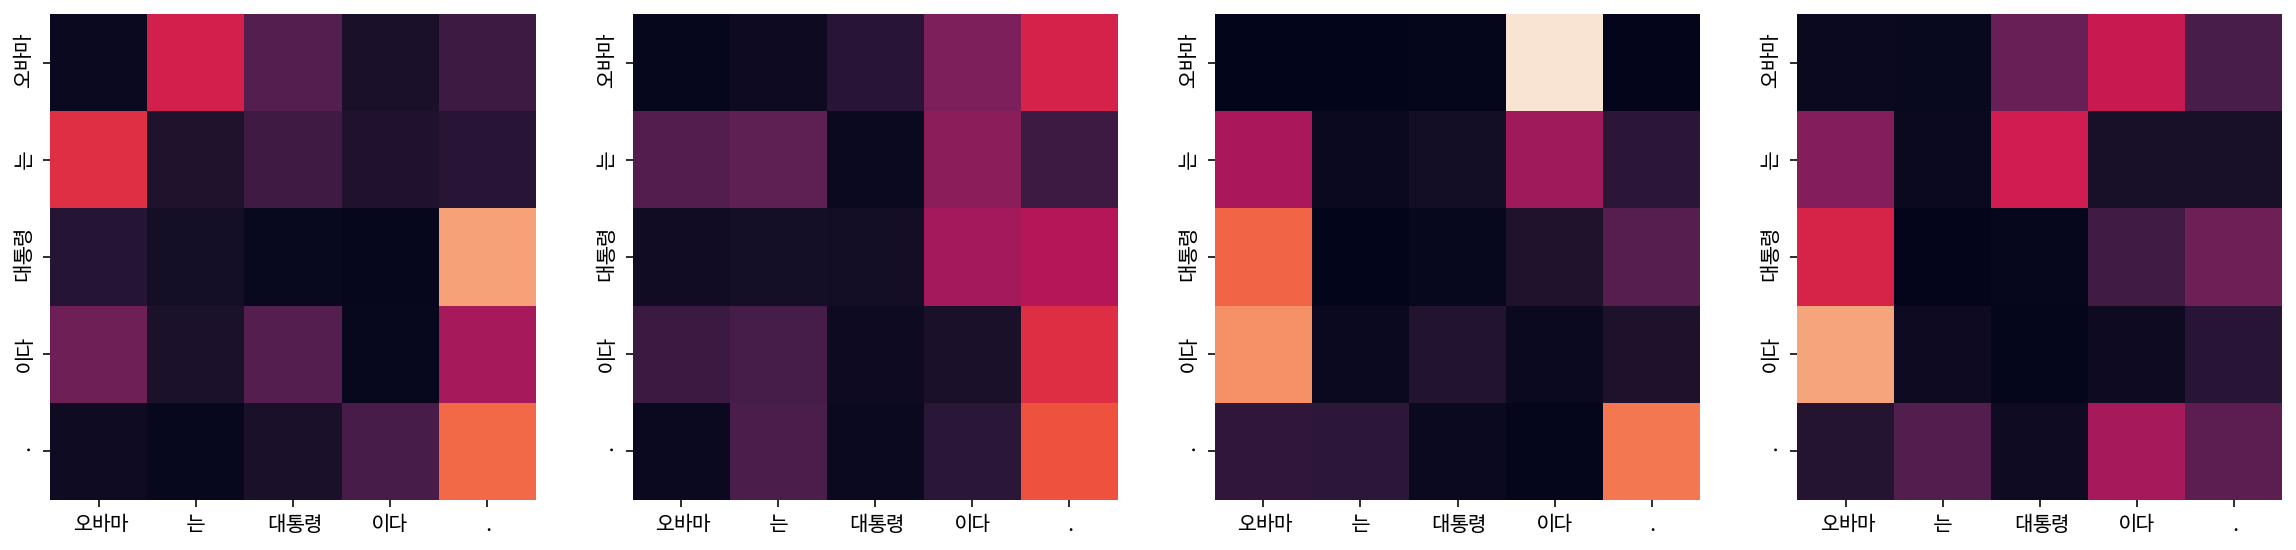

Encoder Layer 2


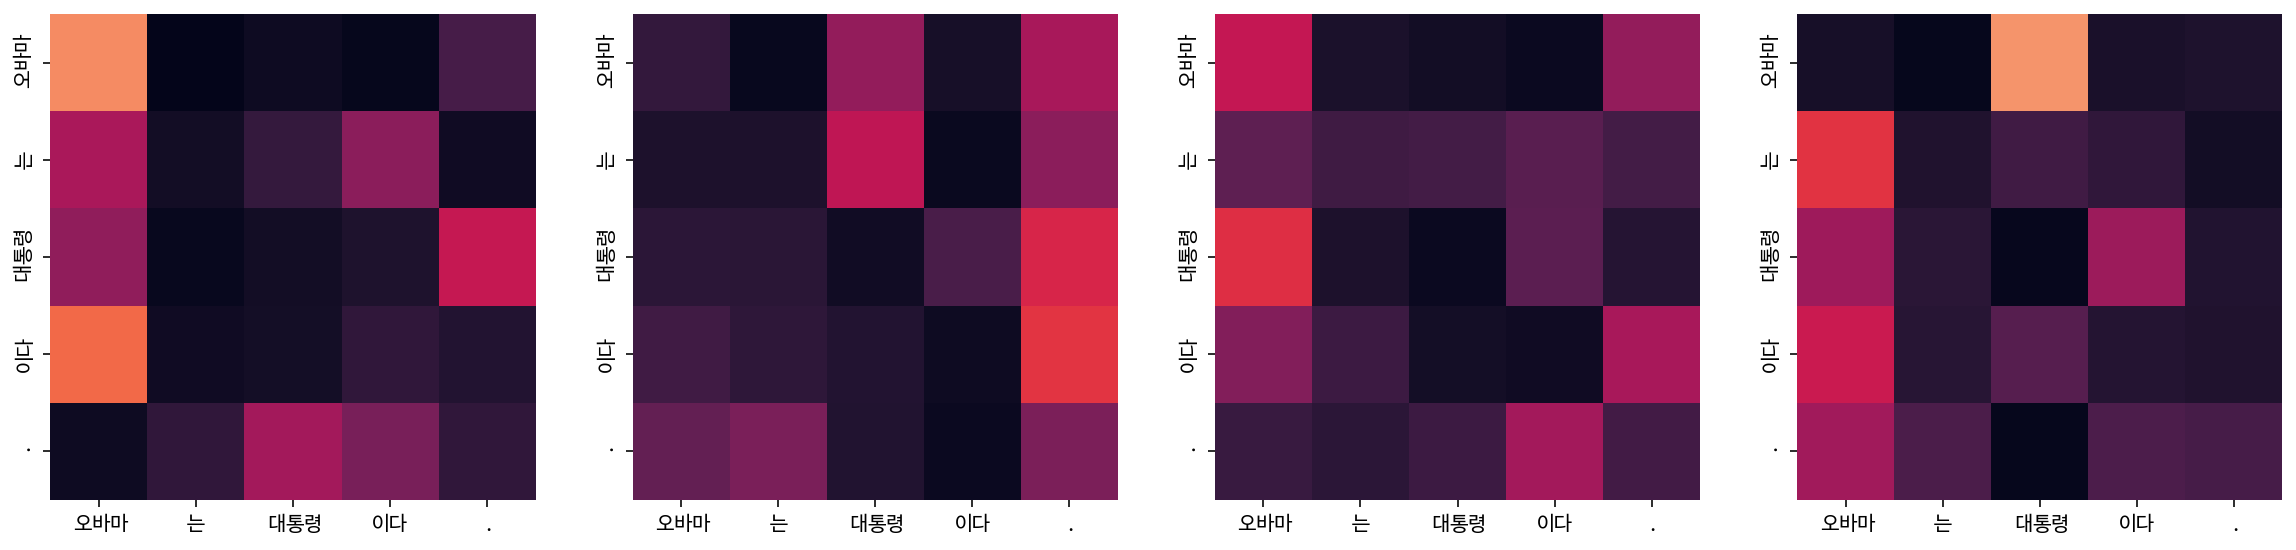

Decoder Self Layer 1


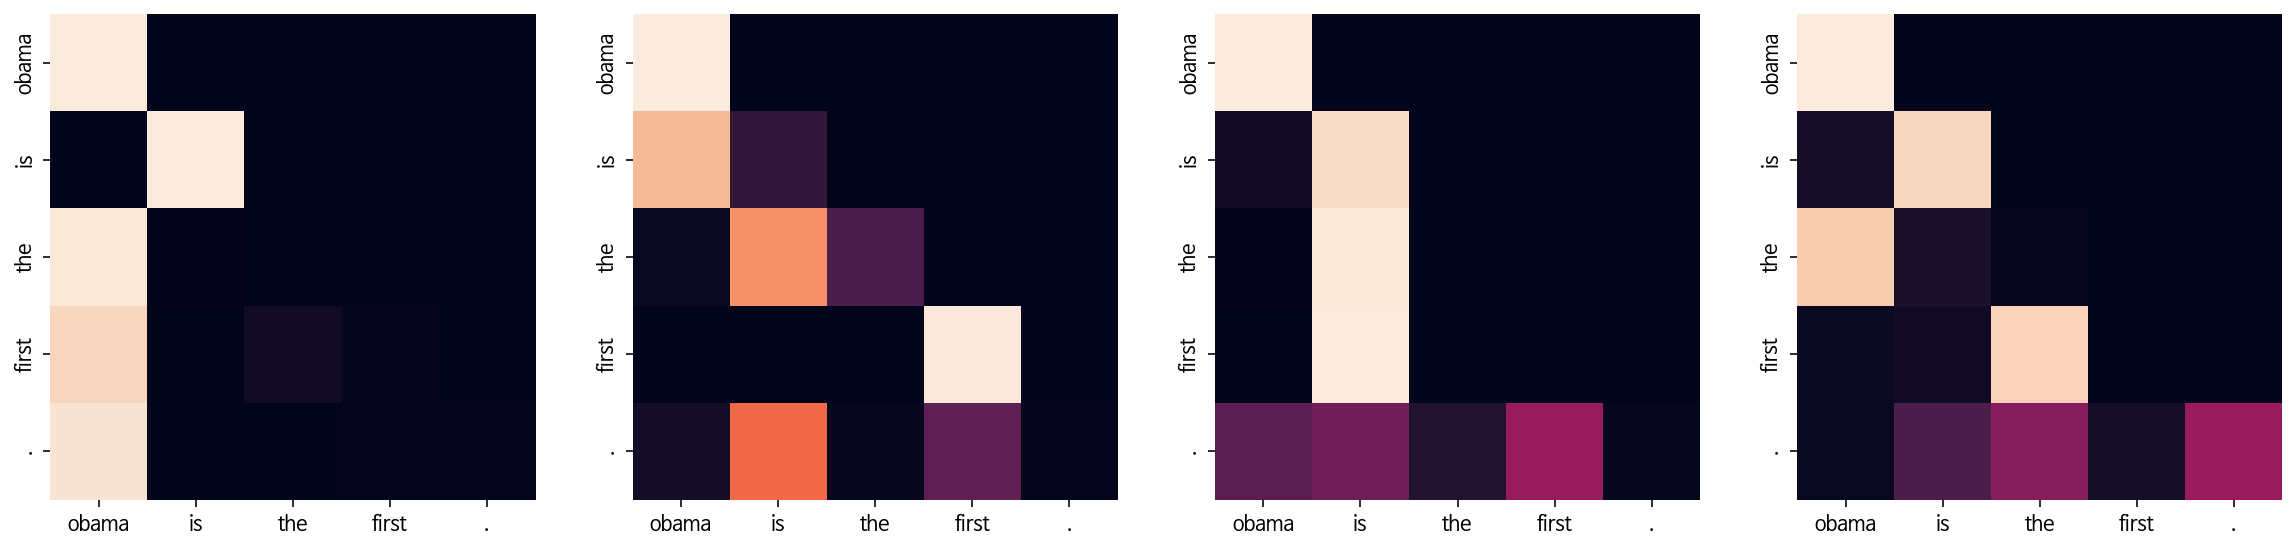

Decoder Src Layer 1


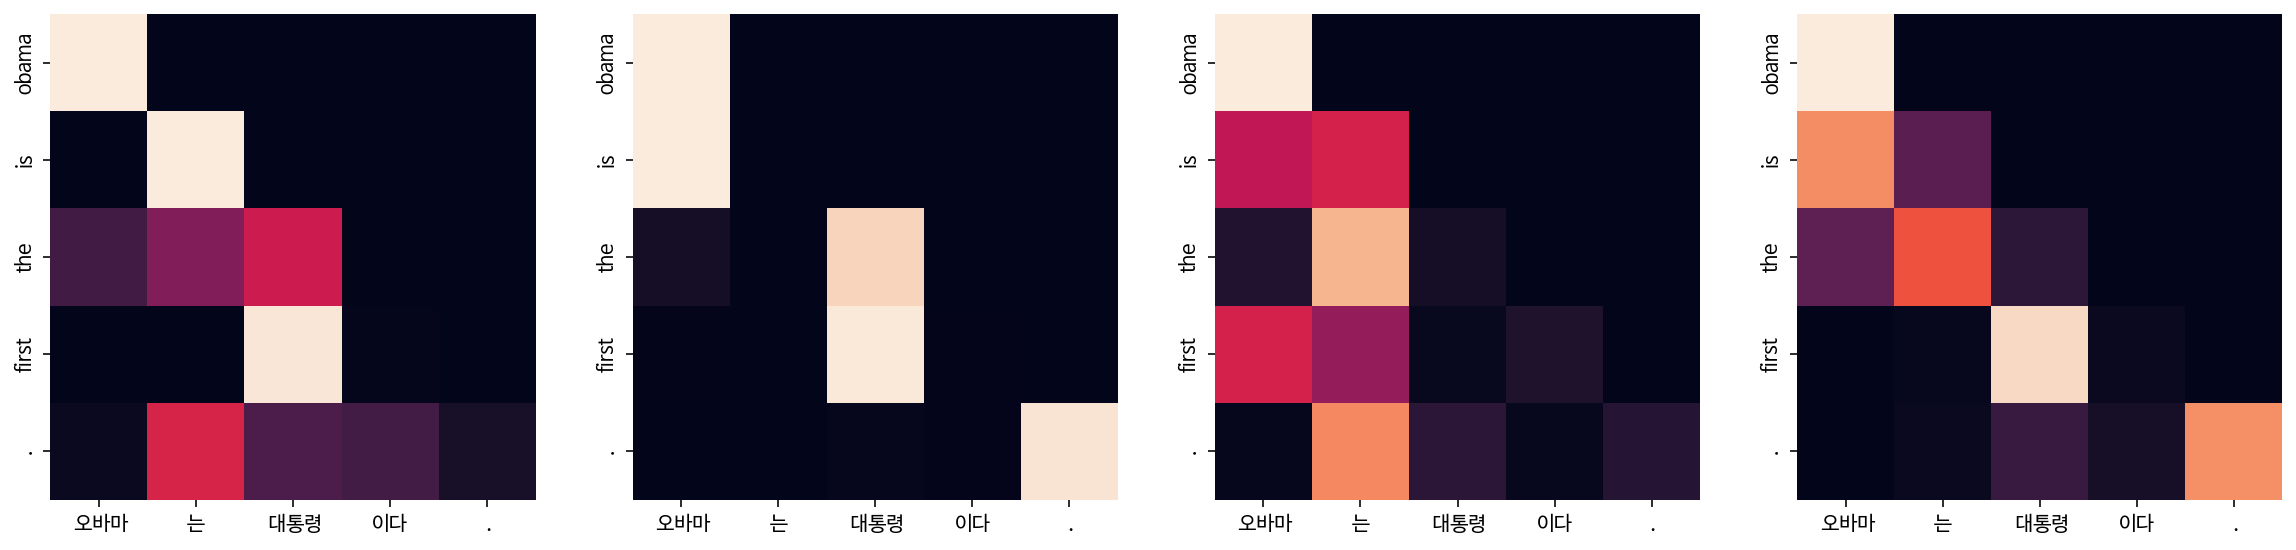

Decoder Self Layer 2


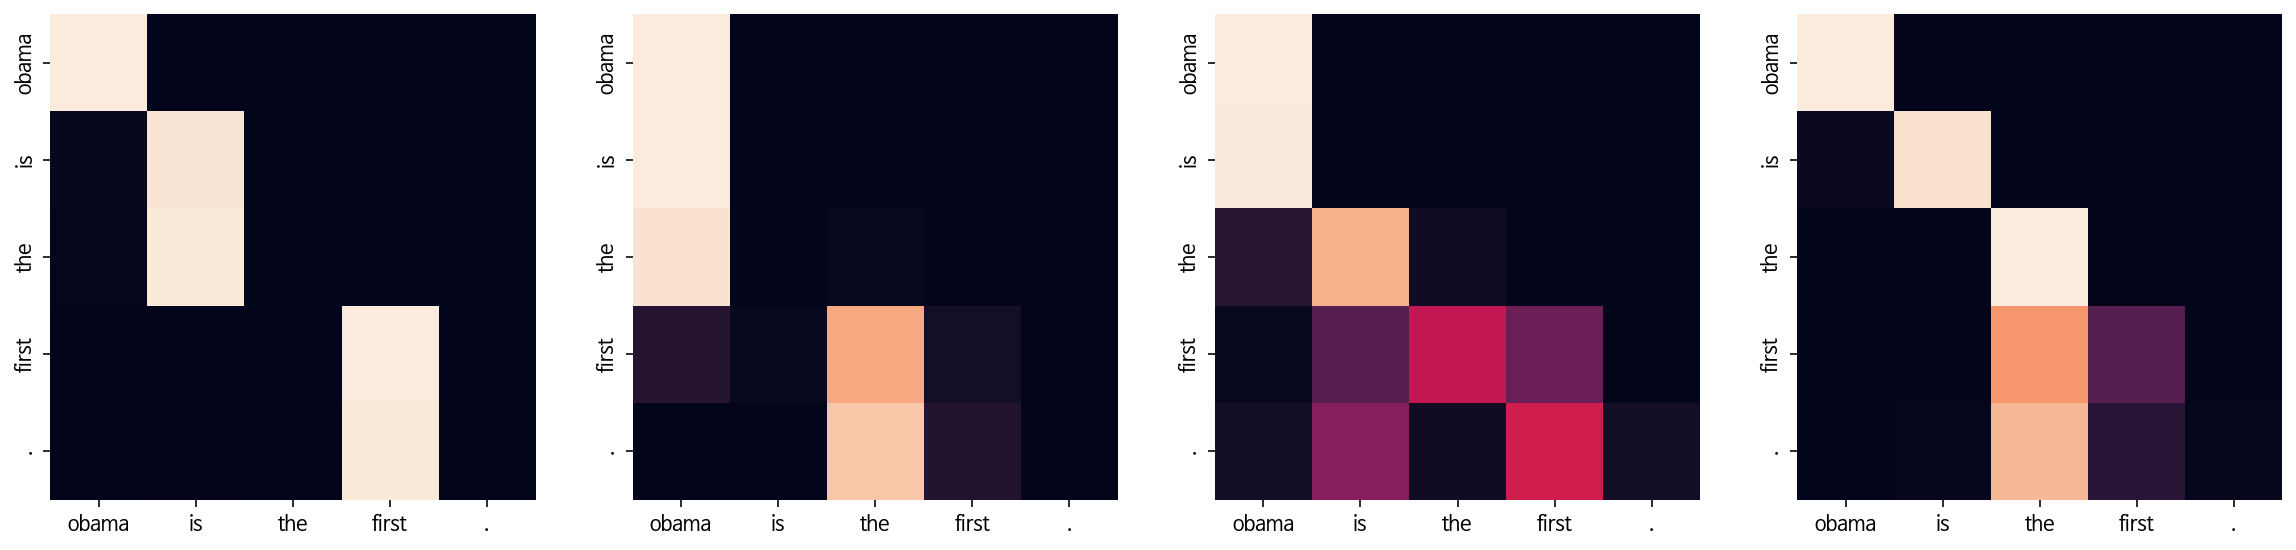

Decoder Src Layer 2


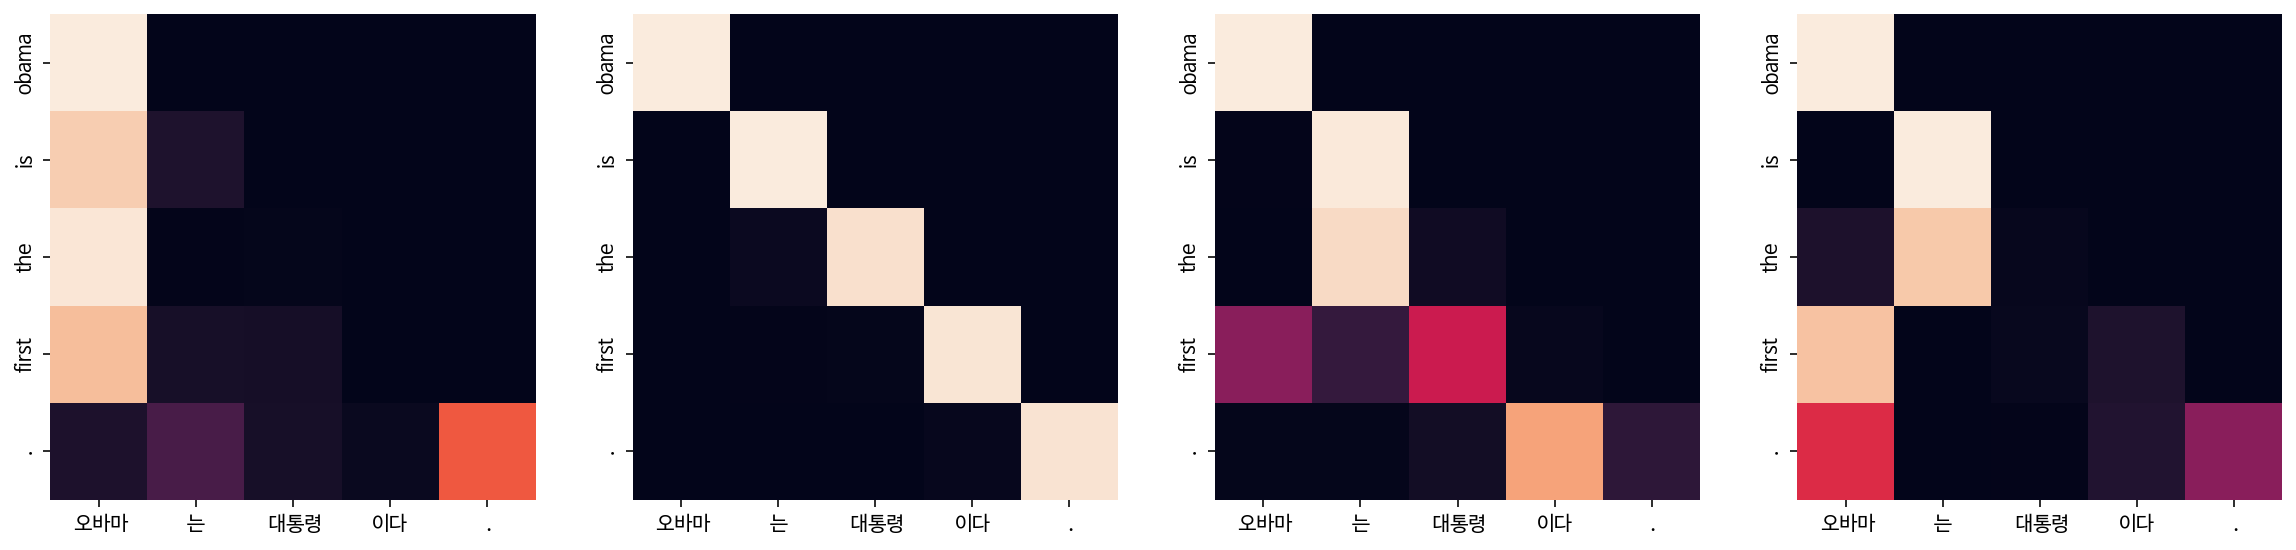

In [103]:
sentence = '오바마는 대통령이다.'
translate('오바마는 대통령이다.',transformer, ko_tokenizer, en_tokenizer,True)

1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: the gunman marked the left mountain .
Encoder Layer 1


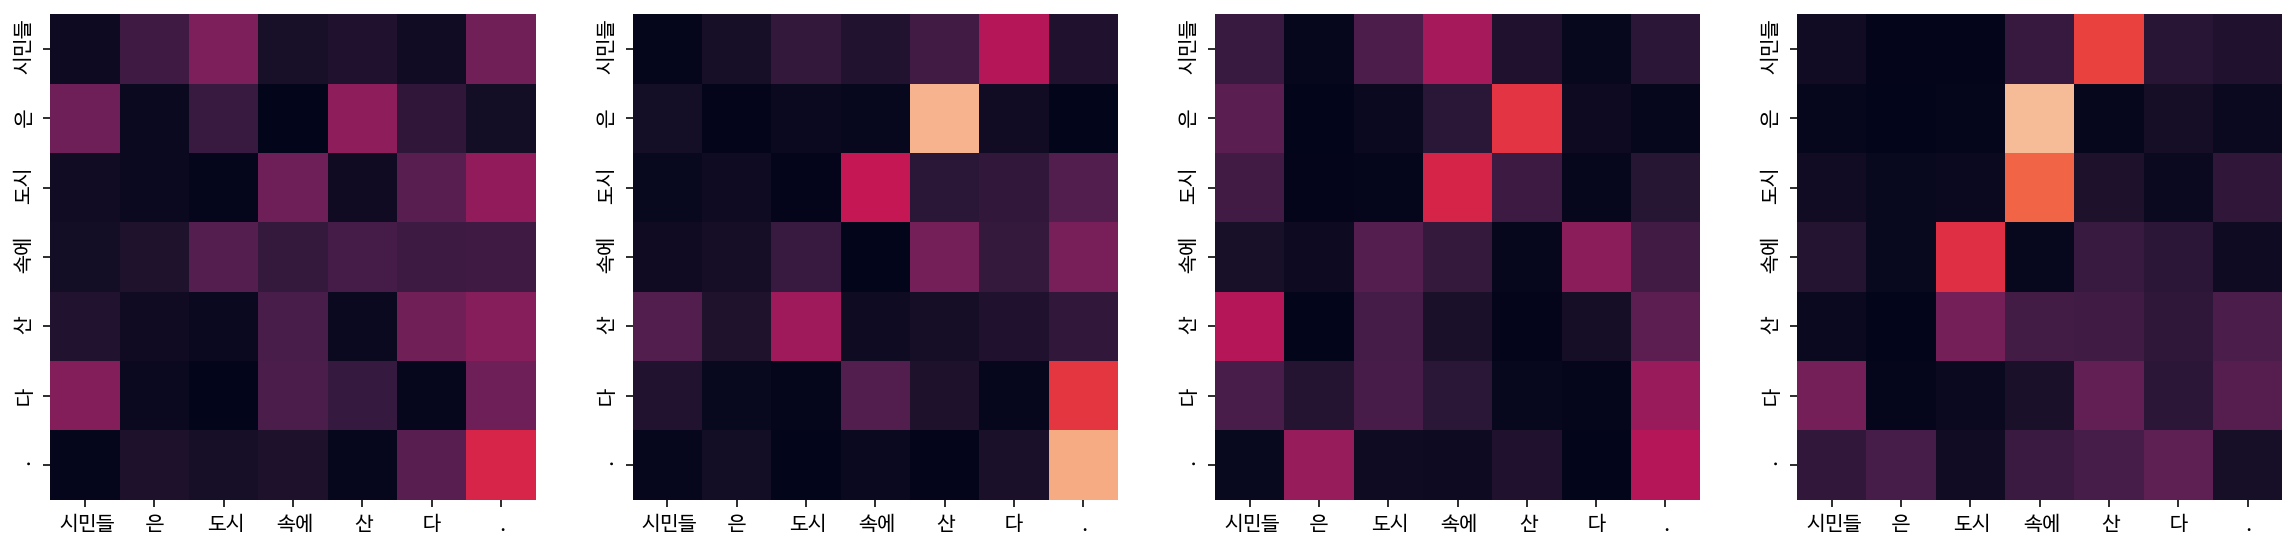

Encoder Layer 2


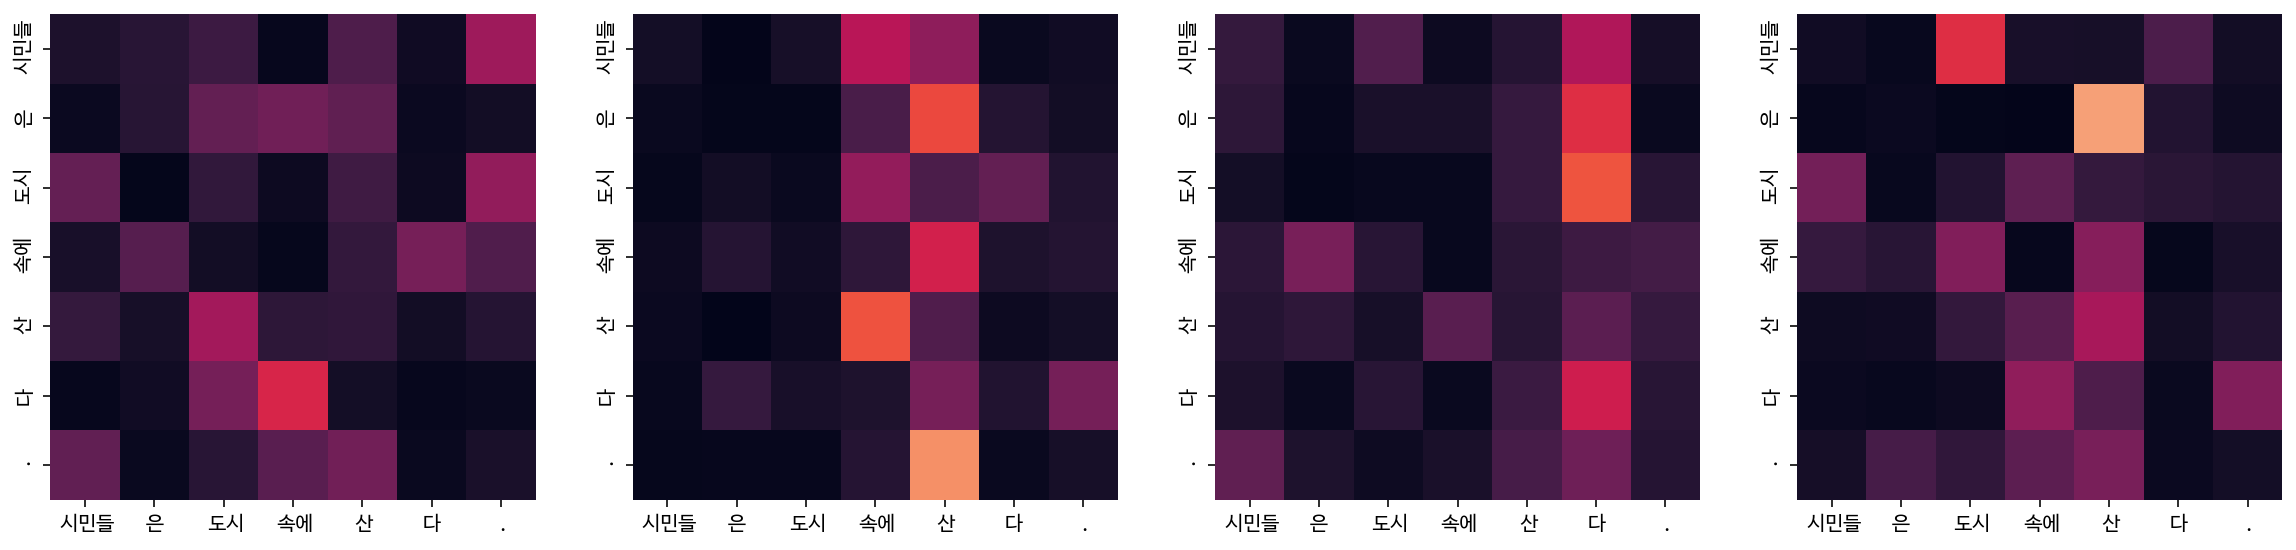

Decoder Self Layer 1


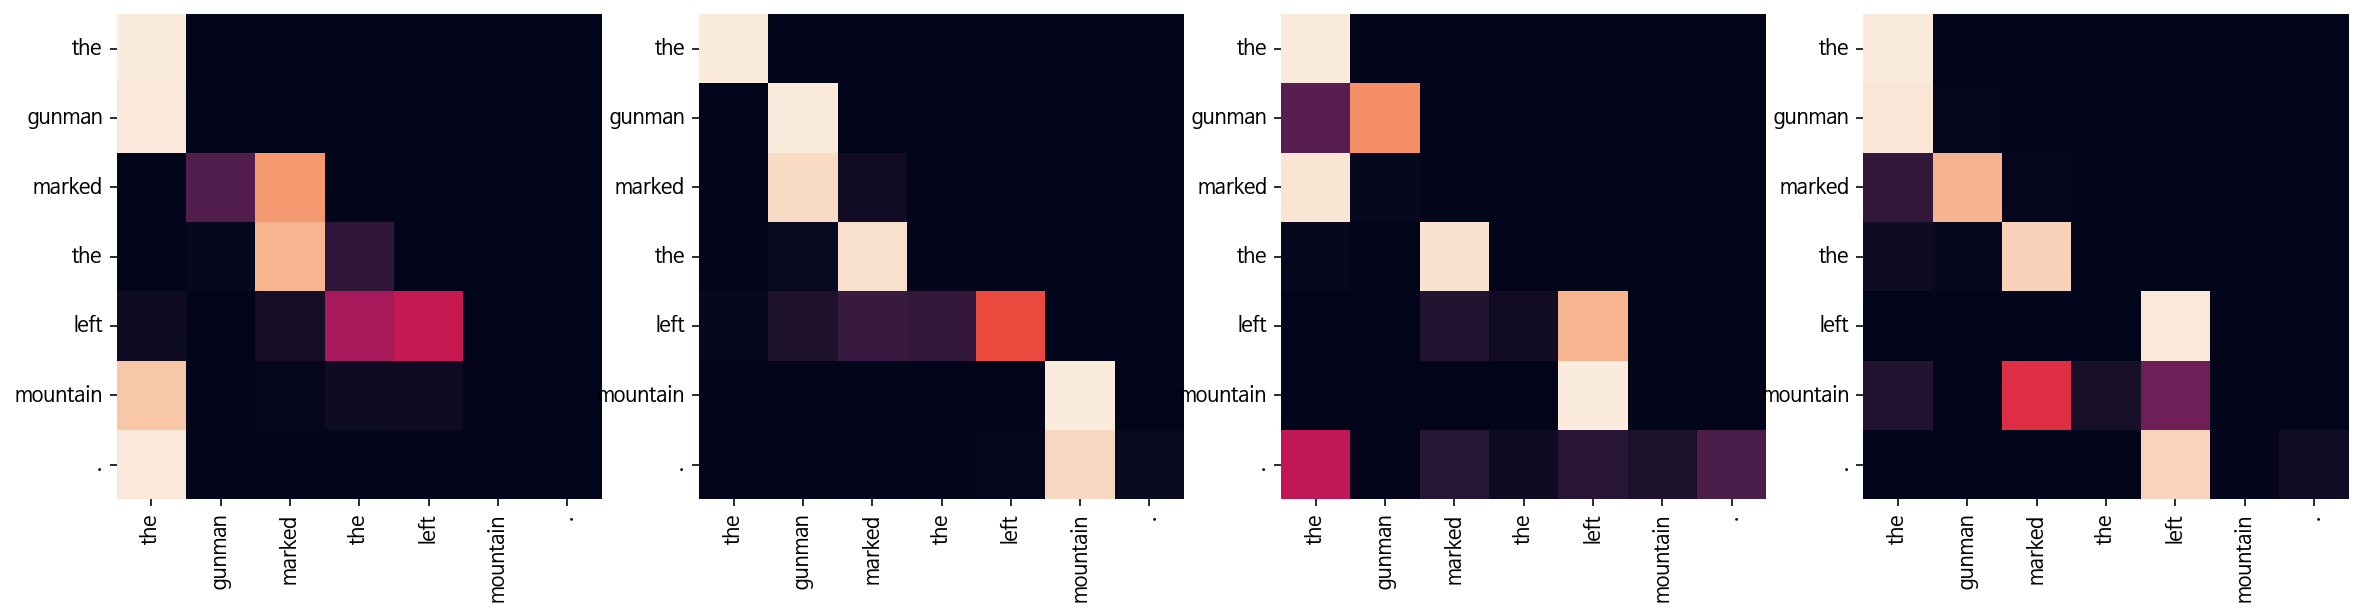

Decoder Src Layer 1


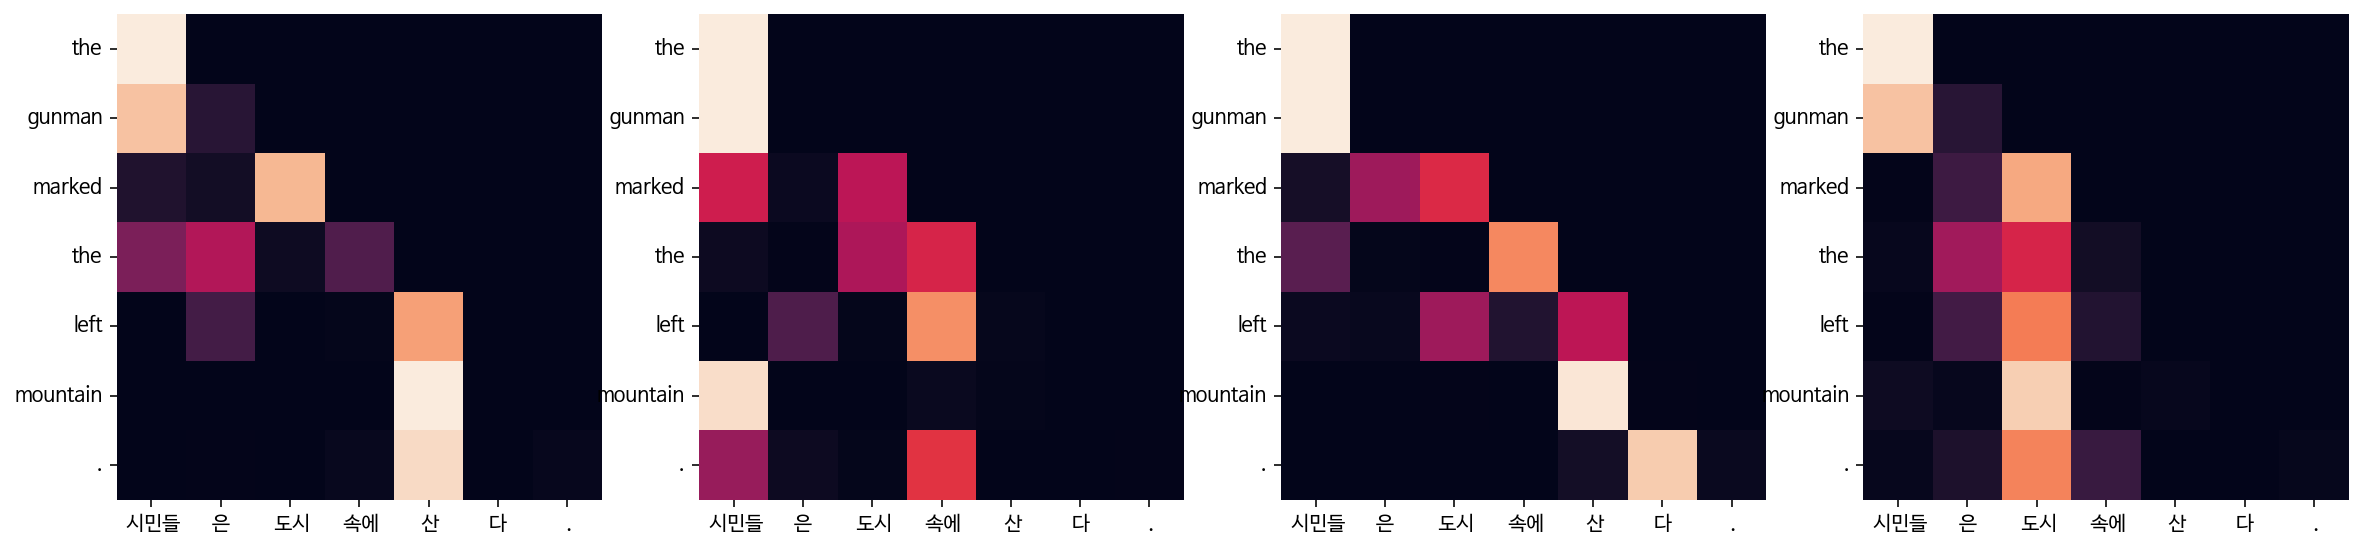

Decoder Self Layer 2


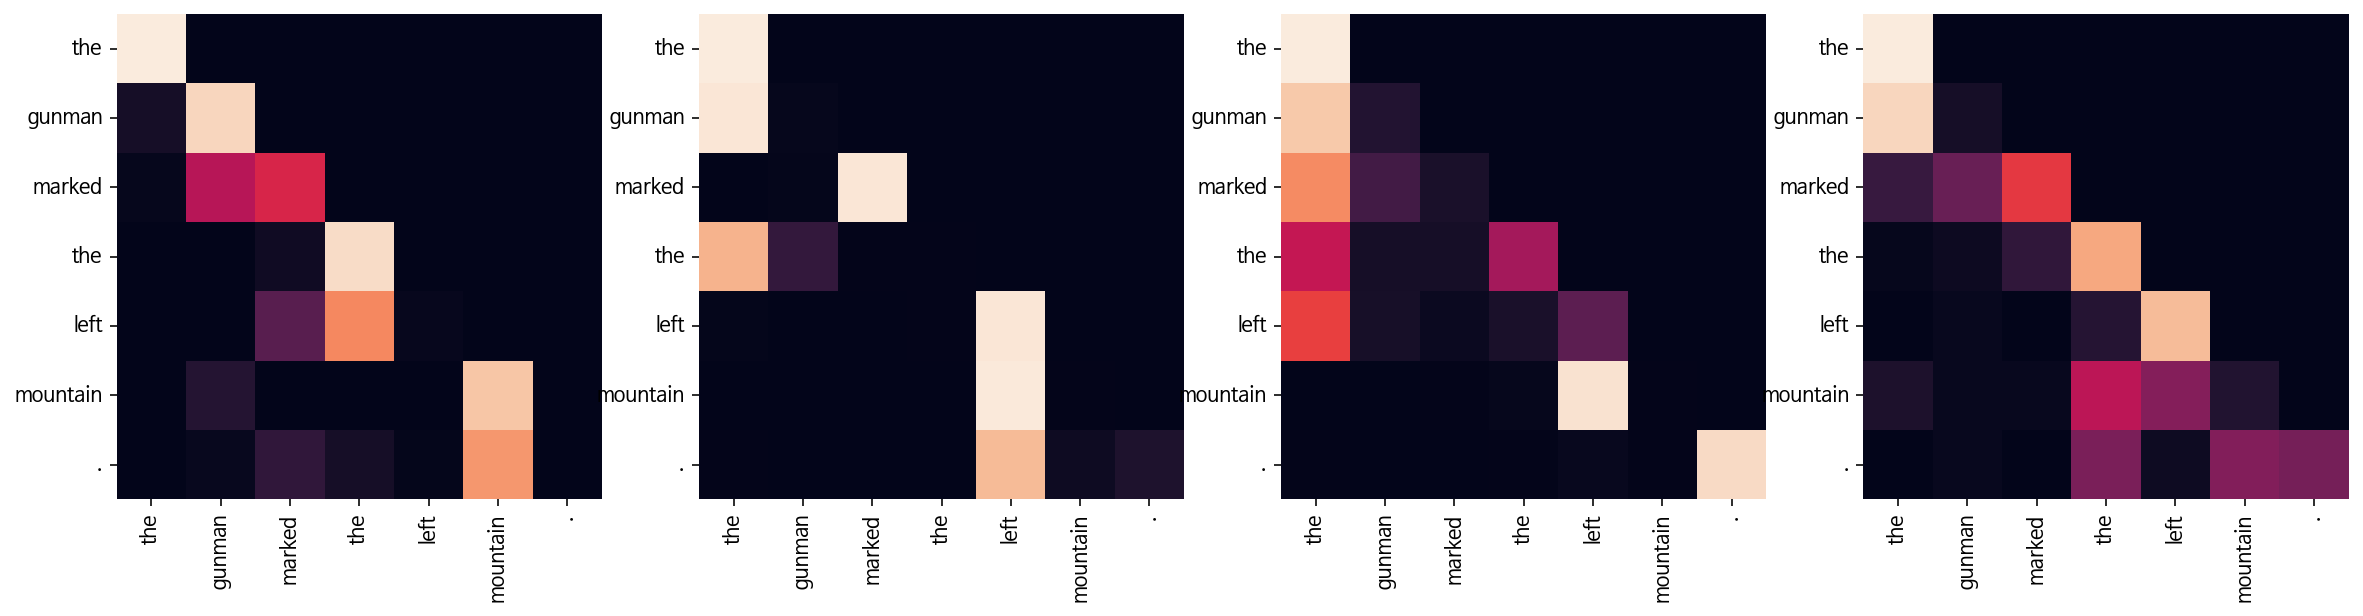

Decoder Src Layer 2


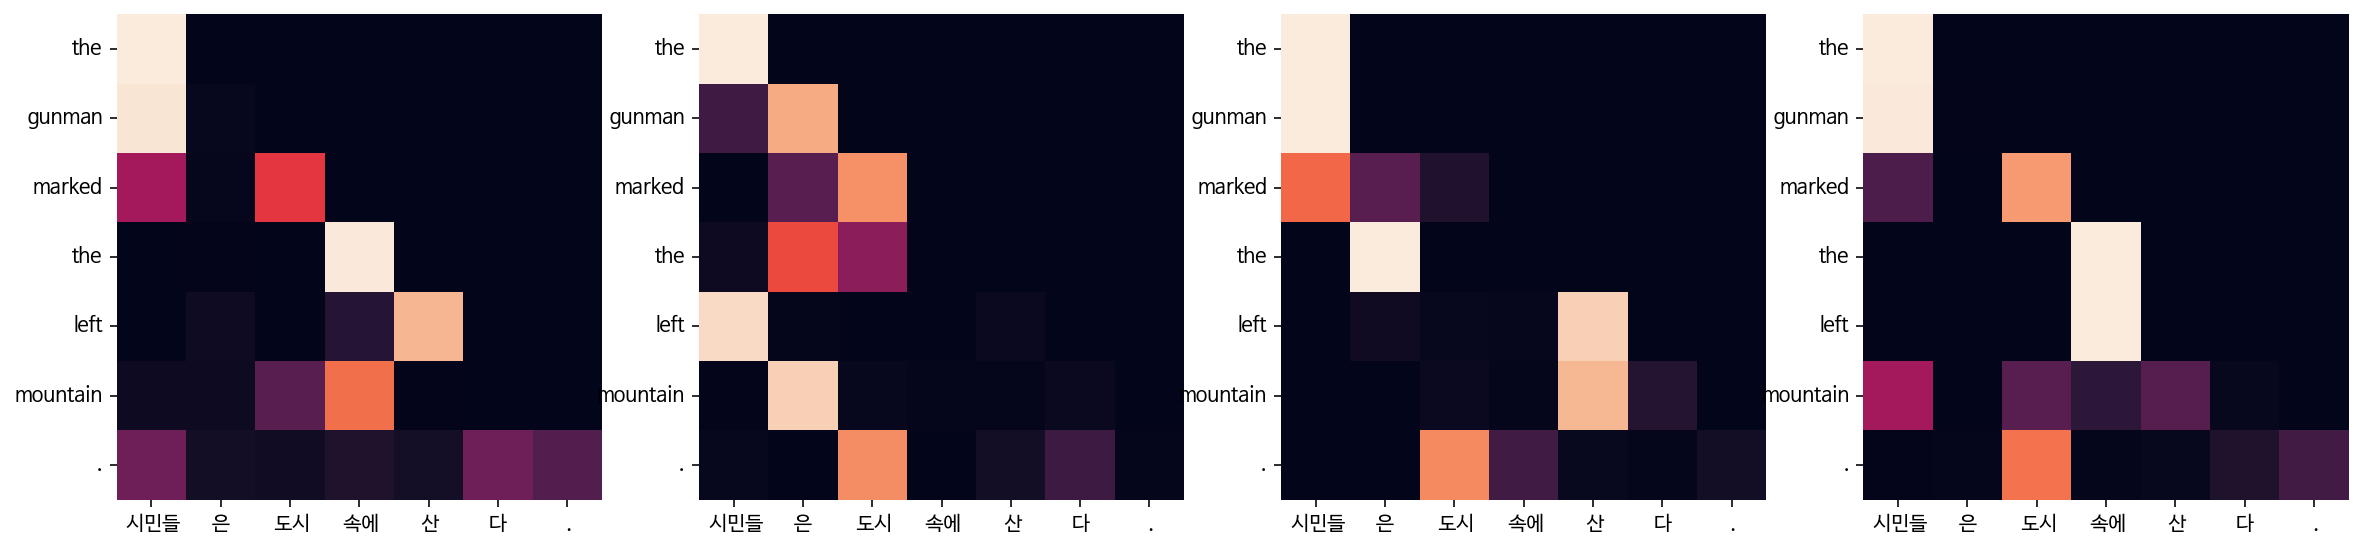

In [104]:
sentence = '시민들은 도시 속에 산다.'
translate('시민들은 도시 속에 산다.',transformer, ko_tokenizer, en_tokenizer,True)

1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were in risen to seven people .
Encoder Layer 1


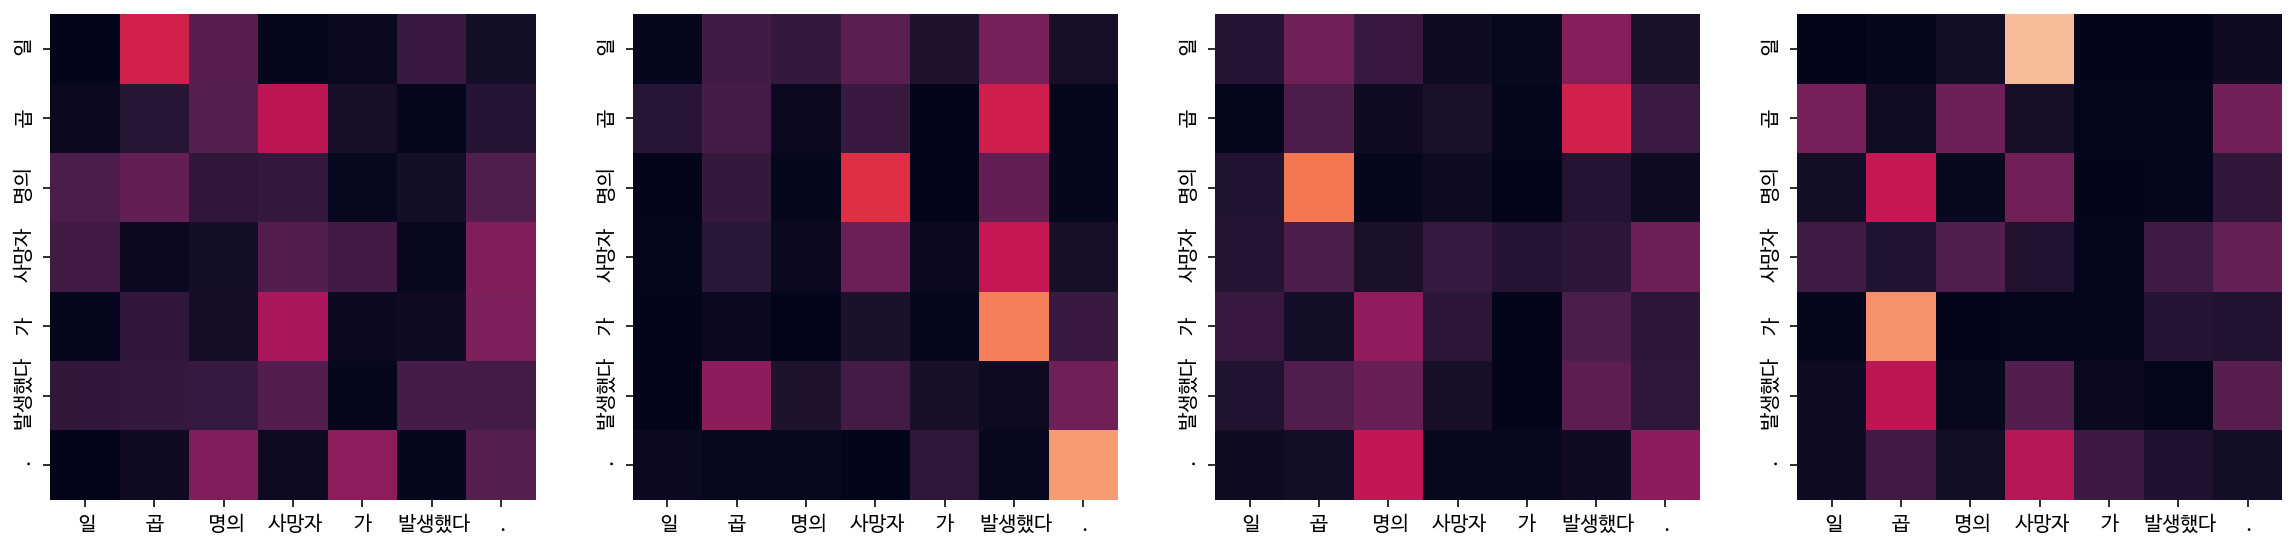

Encoder Layer 2


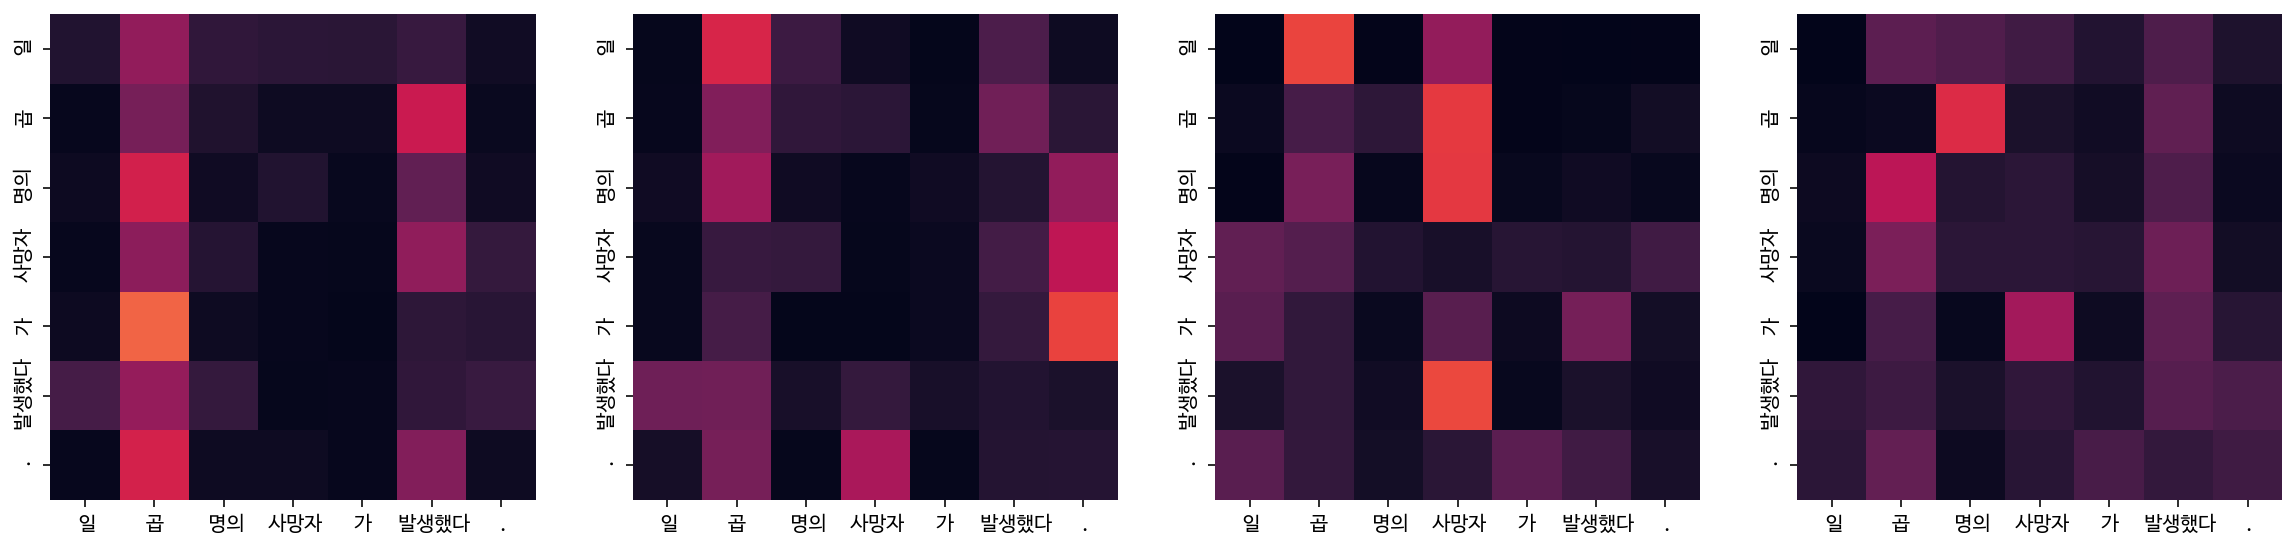

Decoder Self Layer 1


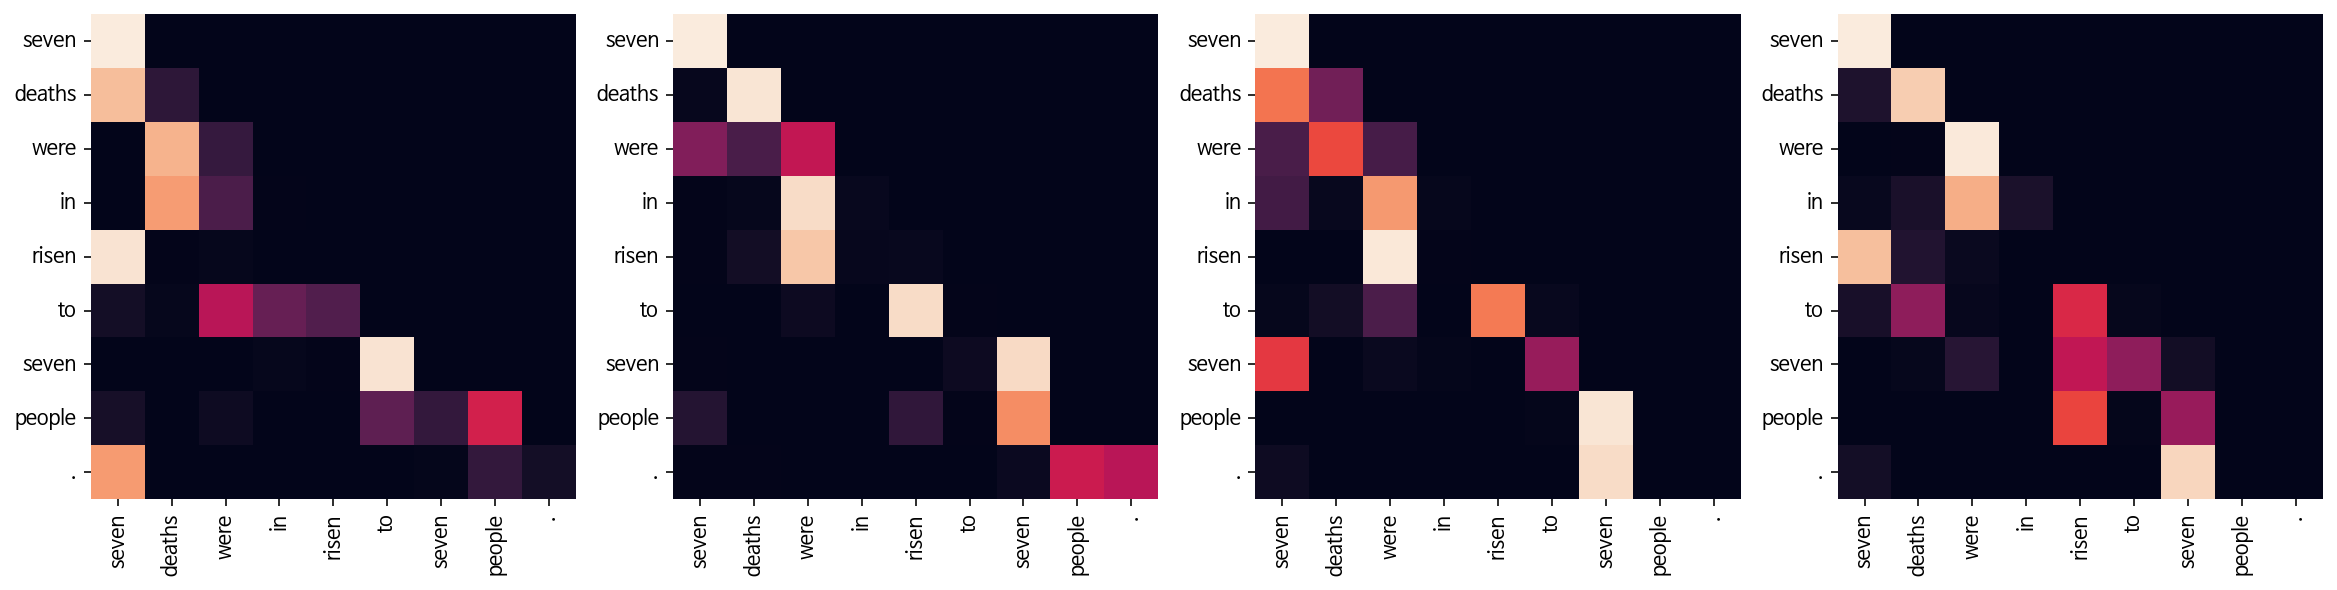

Decoder Src Layer 1


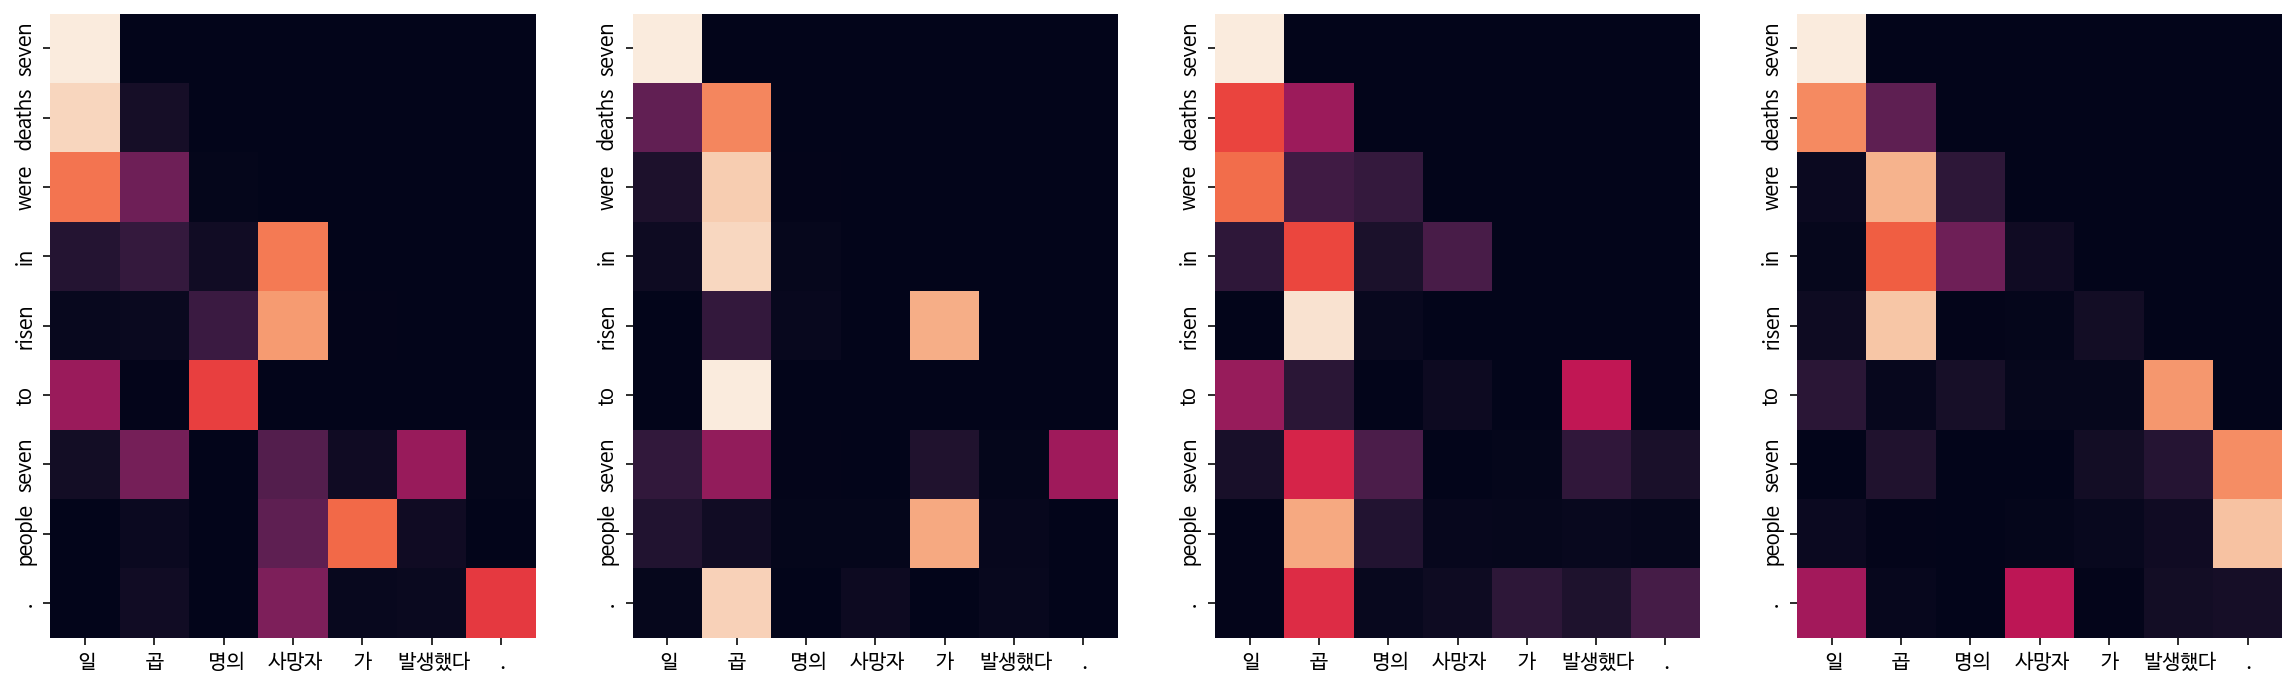

Decoder Self Layer 2


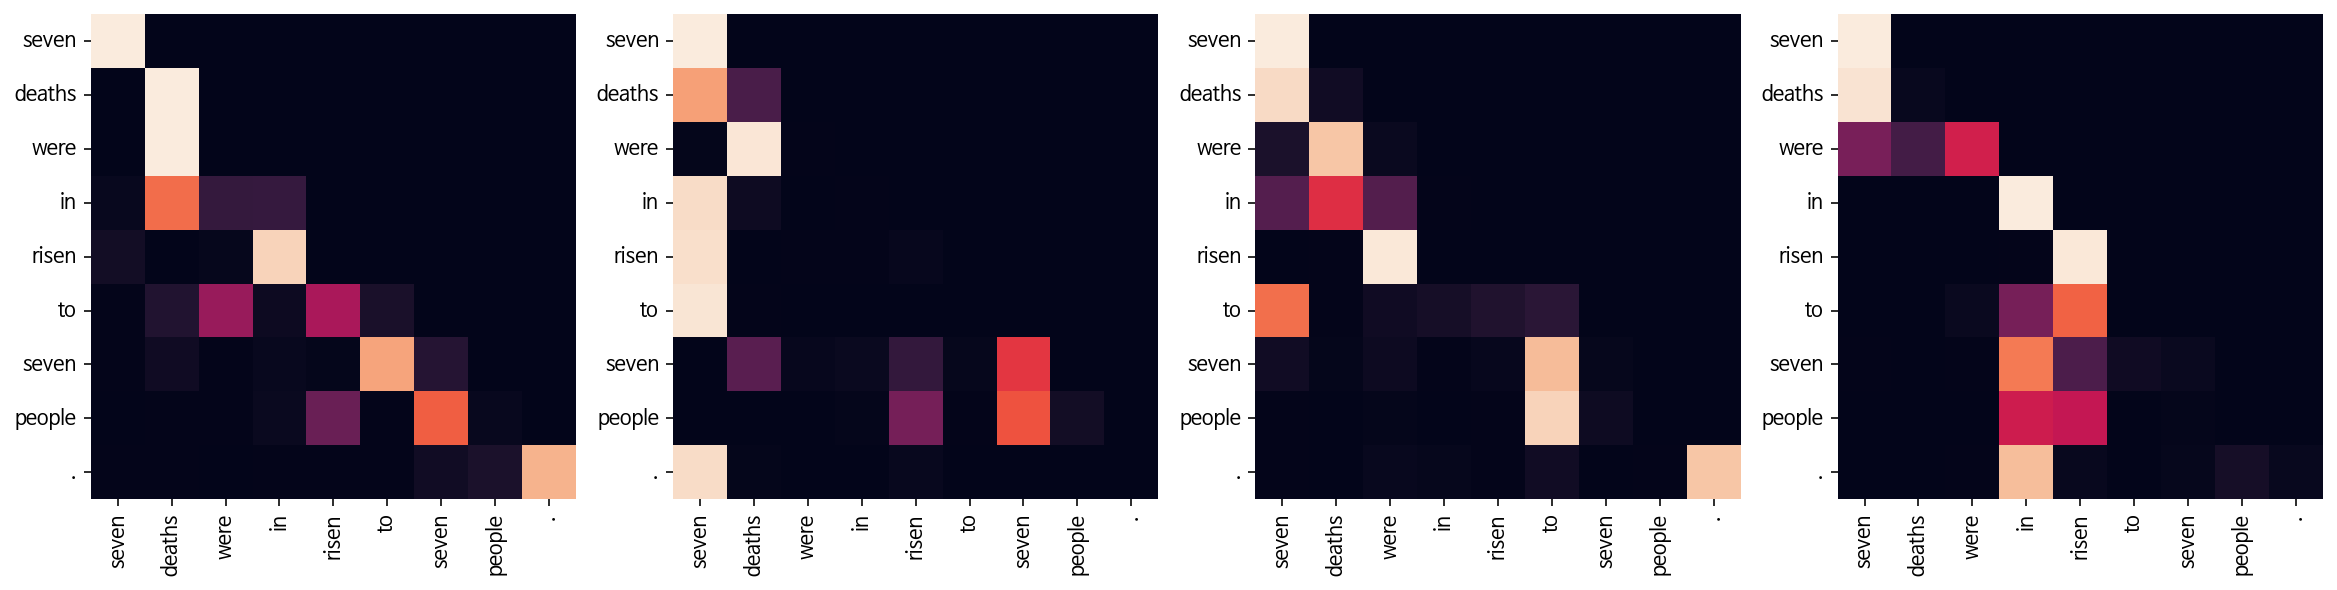

Decoder Src Layer 2


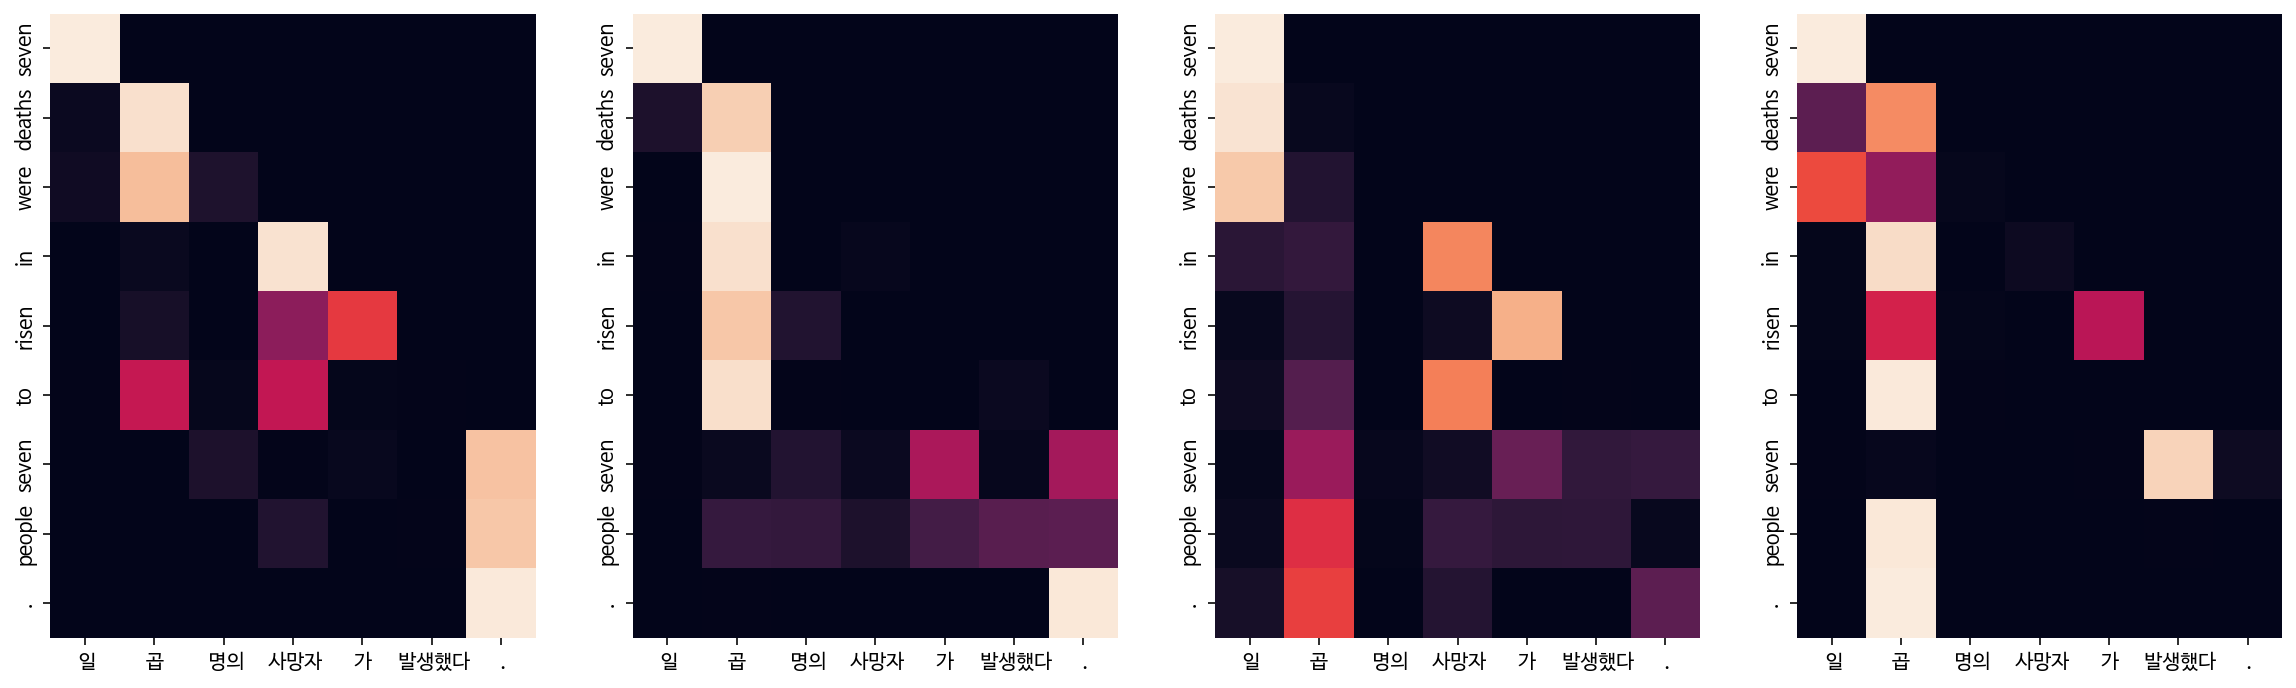

In [105]:
sentence = '일곱 명의 사망자가 발생했다.'
translate('일곱 명의 사망자가 발생했다.',transformer, ko_tokenizer, en_tokenizer,True)